# DE-MC sampling of MLP weights using iris data

Sampling the weights of a multi-layer perceptron (MLP) using the iris data and DE-MC algorithm.

In [1]:
## Import packages

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.mcmc import DEMC

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Avoid issuing memory warning due to number of plots

plt.rcParams.update({'figure.max_open_warning': 0})

In [9]:
## Load iris data

num_chains = 10

dataloaders = [DataLoader(indexify(Iris)(), batch_size=150, shuffle=True) for i in range(num_chains)]

In [10]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 3, 3], activations=[torch.sigmoid, None])

models = [mlp.MLP(
    hparams=hparams,
    loss=lambda x, y: nn.CrossEntropyLoss(reduction='sum')(x, torch.argmax(y, 1)),
    dtype=torch.float64
) for i in range(num_chains)]

for i in range(num_chains):
    models[i].prior = Normal(
        torch.zeros(models[i].num_params(), dtype=models[i].dtype),
        np.sqrt(3)*torch.ones(models[i].num_params(), dtype=models[i].dtype)
    )

In [11]:
## Set initial values of chains

theta0 = models[num_chains-1].prior.sample()
theta0s = [theta0.clone().detach() for _ in range(num_chains)]

In [12]:
## Setup DEMC sampler

sigmas = [torch.tensor(models[i].num_params()*[1.], dtype=models[i].dtype) for i in range(num_chains)]
c = num_chains * [1.]
sampler = DEMC(models, theta0s, dataloaders, sigmas, num_chains=num_chains)

In [13]:
## Run PowerPosteriorSampler

start_time = timer()

sampler.run(num_iterations=1100, num_burnin=100, verbose=True, verbose_step=100)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Iteration  100, duration 0:00:00.153235
Iteration  200, duration 0:00:00.154149
Iteration  300, duration 0:00:00.151474
Iteration  400, duration 0:00:00.159651
Iteration  500, duration 0:00:00.149952
Iteration  600, duration 0:00:00.151194
Iteration  700, duration 0:00:00.156213
Iteration  800, duration 0:00:00.151564
Iteration  900, duration 0:00:00.148865
Iteration 1000, duration 0:00:00.153652
Iteration 1100, duration 0:00:00.155864
Time taken: 0:02:51.109057


In [ ]:
## Compute Monte Carlo mean

torch.stack([sampler.samplers[i].chain.mean() for i in range(num_chains)]).mean(0)

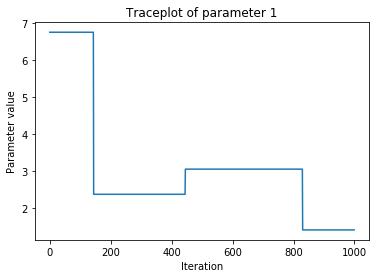

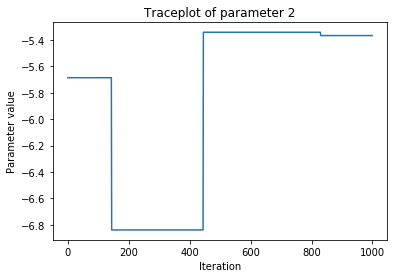

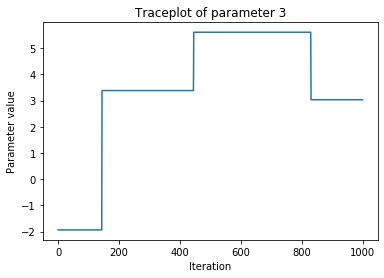

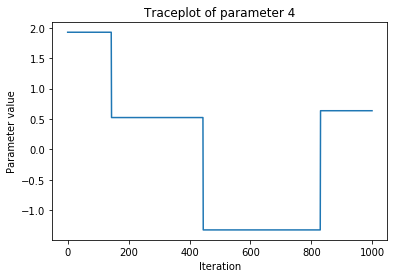

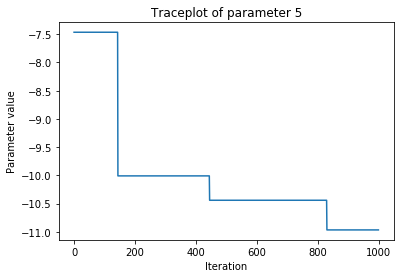

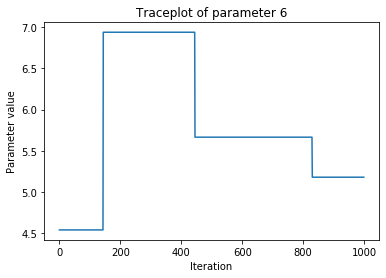

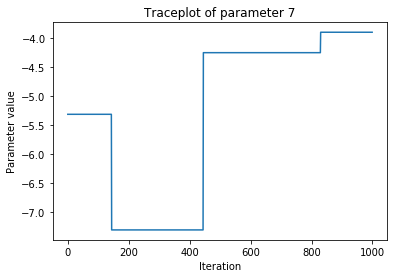

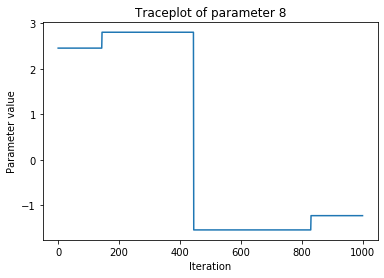

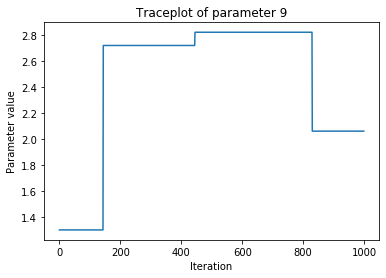

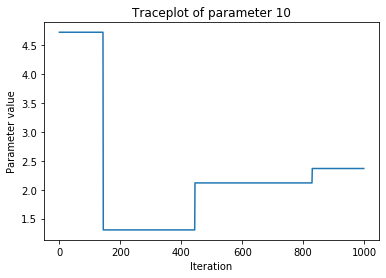

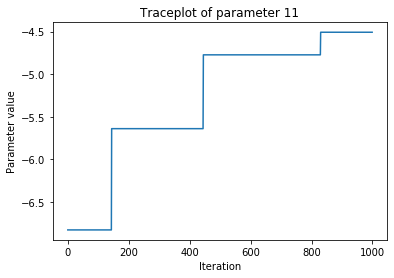

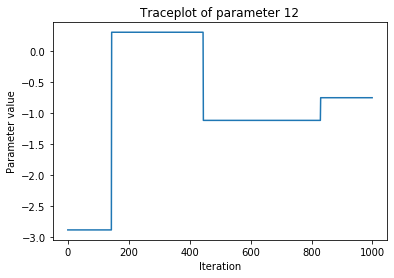

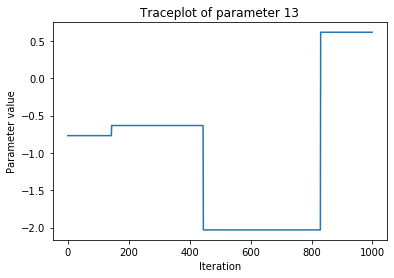

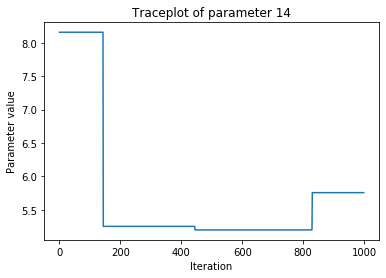

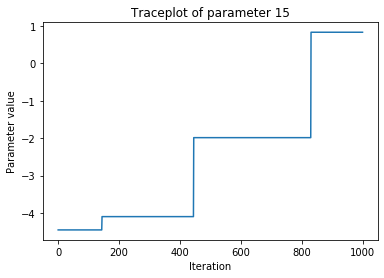

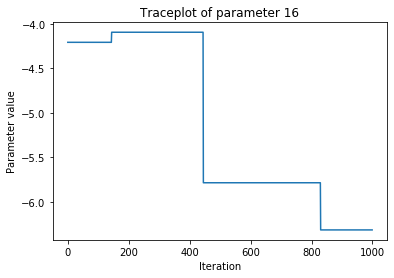

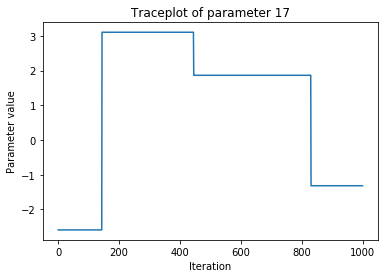

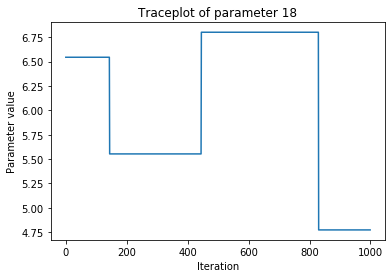

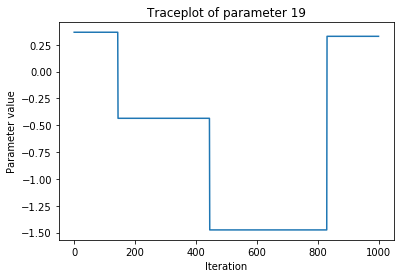

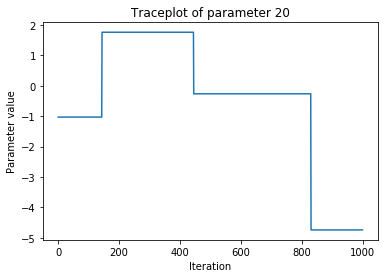

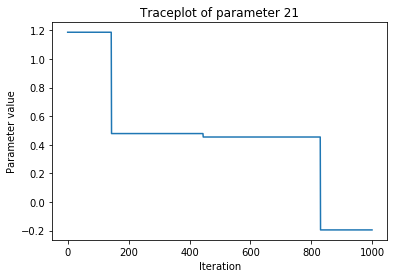

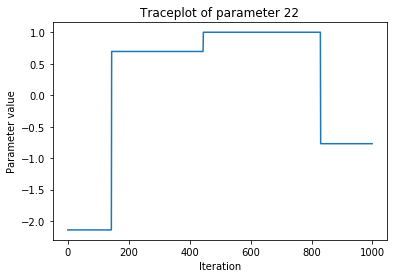

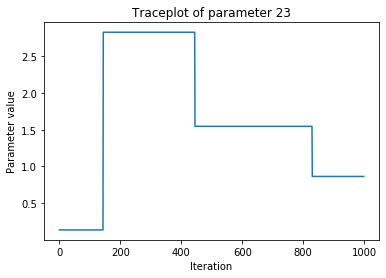

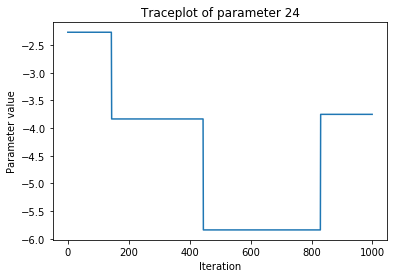

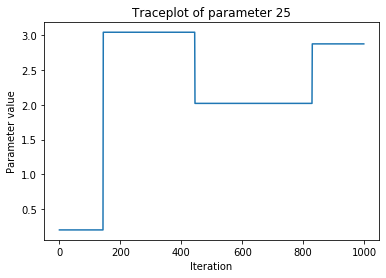

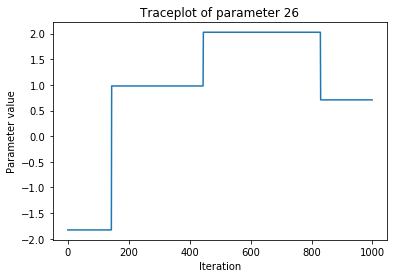

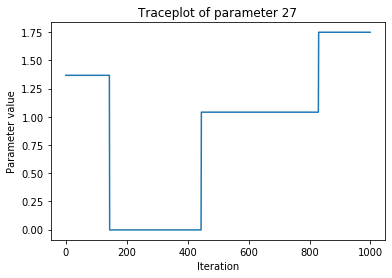

In [14]:
## Plot traces of simulated Markov chain

for i in range(sampler.models[0].num_params()):
    chain = sampler.samplers[0].chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

In [ ]:
## Plot running means of simulated Markov chain

for i in range(models[0].num_params()):
    chain = sampler.get_chain().get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter {}'.format(i+1))

In [ ]:
## Plot histograms of simulated Markov chain

for i in range(models[0].num_params()):
    plt.figure()
    sns.distplot(sampler.get_chain().get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter {}'.format(i+1))